# Lab Assignment Seven: RNNs

### Luis Garduno

Dataset : [Sentiment140 Kaggle Dataset](https://www.kaggle.com/kazanova/sentiment140) 

----------------------------

## 1. Preparation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Data Preparation

In [1]:
import glob, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tkinter import Tcl
from skimage.io import imshow
from sklearn import metrics as mt
from sklearn import preprocessing
%matplotlib inline

le = preprocessing.LabelEncoder()

# Load in Sentiment140 Dataset in pandas array
df = pd.read_csv('../data/Sentiment140/training.1600000.processed.noemoticon.csv',
                 names=['polarity', 'id', 'date', 'query', 'user', 'tweet'],
                 encoding='ISO-8859-1')

# Create sample (Remove later)
df = df.sample(frac=1)
df = df[:200000]

print("Number of Total Tweets:", len(df), "\n")

# Check if our dataset is missing any columns
df.info()

Number of Total Tweets: 200000 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 953713 to 841974
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  200000 non-null  int64 
 1   id        200000 non-null  int64 
 2   date      200000 non-null  object
 3   query     200000 non-null  object
 4   user      200000 non-null  object
 5   tweet     200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


| Field | Description | Type |
| ----- | ----------- | ---- |
| **Polarity** | &nbsp;&nbsp;&nbsp; - The target/polarity of the tweet <br /> &nbsp;&nbsp; [0] Negative; [2] Neutral; [4] Positive; | Discrete |
| **id**    | &nbsp;&nbsp;&nbsp; - The id of the tweet    | Discrete |
| **date**  | &nbsp;&nbsp;&nbsp; - The date of the tweet  | Interval |
| **query** | &nbsp;&nbsp;&nbsp; - The query | Nominal |
| **user**  | &nbsp;&nbsp;&nbsp; - The user that tweeted  | nominal  |
| **tweet**  | &nbsp;&nbsp;&nbsp; - The text of the tweet  | nominal  |

polarity         2
id          199978
date        175362
query            1
user        148805
tweet       199110
dtype: int64

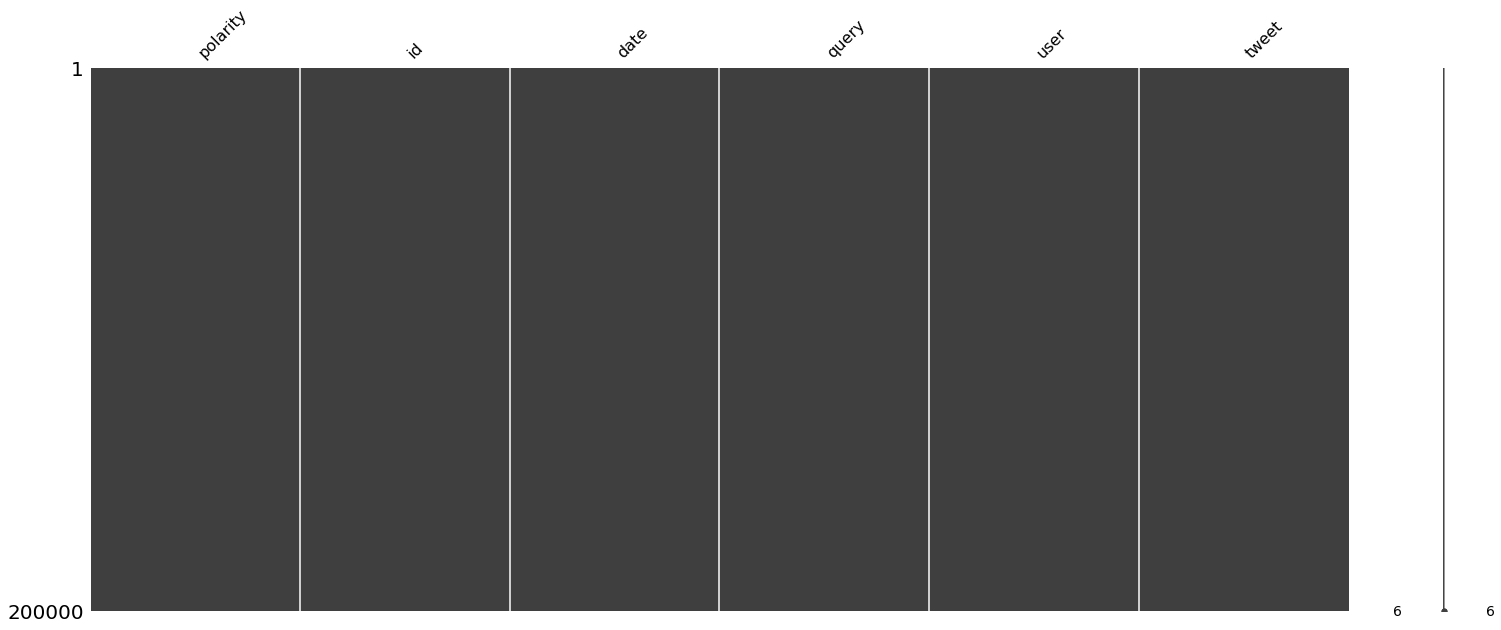

In [2]:
import missingno as mn

# Check for any missing/null values within dataset
mn.matrix(df)

# Find unique values within each field, before dropping columns.
df.nunique()

After outputting all of the unique values, we see that there is only 1 unique value
within the query field, meaning that it will not make an impact when further doing
our analysis because all the values are the same. Other fields that can be dropped
are the user tweet id, username, iand date because these these do not impact whether a
user's tweet is negative or positive.

Addtionally we're able to see that there's 2 unique values within the polarity field,
it is probably best to find out what these two values are and change them so that 0
equals negative and 1 equals positive.

In [3]:
# Drop the fields we don't need
df.drop(['id', 'date', 'query','user'], axis=1, inplace=True)

# Find the 2 unique polarity fields
df['polarity'].unique()

array([4, 0])

Text(0, 0.5, 'Number of Tweets')

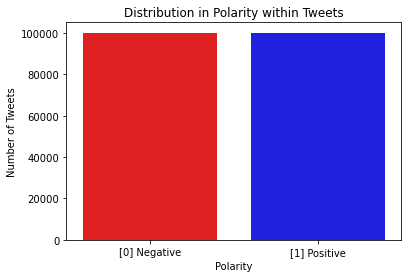

In [4]:
# Change [4] to [1] so the data is easier to understand.
df['polarity'] = df['polarity'].replace(4,1)

# Visualize whether data is evenly divided in terms of the polarity of tweets.
ax = sns.countplot(x="polarity", data=df, palette=['red', 'blue'])
ax.set_title('Distribution in Polarity within Tweets')
ax.set_xlabel('Polarity')
ax.set_xticks([0,1])
ax.set_xticklabels(['[0] Negative', '[1] Positive'])
ax.set_ylabel('Number of Tweets')

In [5]:
# Check for proper variable representations
# Make all tweets lowercase for future processing
df['tweet'] = df['tweet'].astype('str')
df['tweet'] = df['tweet'].str.lower()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 953713 to 841974
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  200000 non-null  int64 
 1   tweet     200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.6+ MB


#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Text/Word Pre-processing

For this section I used some of the most common text-preprocessing that are practiced
in Natural Language Processing projects such as:     
- Removing stop words     
- Stemming words     
- Lemmatizing words
- Tokenizing individual words

In [6]:
import nltk
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer

stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))
txt_rm = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# First we tokenize the words for the tweets 
#tweet_tokenizer= TweetTokenizer(reduce_len=False)
#df['tweet'] = df['tweet'].apply(lambda x: tweet_tokenizer.tokenize(x))
#df4 = df
#from copy import deepcopy
#df1 = deepcopy(df)
#df.head(15)

In [7]:
# ============ 1.) Removing HTML Tags, URLs, HashTags, Email Addresses, & tagged usernames with RegEx

# Parse through each of the tweets by using regular expressions to remove specific parts of the text
# RegEx Reference: https://github.com/alvations/nltk/blob/develop/nltk/tokenize/casual.py#L122
hashtag, username=r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""", r"""(?:@[\w_]+)"""
emailAddr,htmlTags,=r"""[\w.+-]+@[\w-]+\.(?:[\w-]\.?)+[\w-]""", r"""<[^>\s]+>"""
urls=r"""(?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:[a-z]{2,13})/)(?:[^\s()<>
    {}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]
    +\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:
    [.\-][a-z0-9]+)*[.](?:[a-z]{2,13})\b/?(?!@))"""

# Remove : hashtags, usernames, htmltags
df.tweet = df.tweet.replace(urls, "" ,regex=True)
df.tweet = df.tweet.replace(username, "" ,regex=True)
df.tweet = df.tweet.replace(hashtag, "" ,regex=True)
df.tweet = df.tweet.replace(htmlTags, "" ,regex=True)



# ============ 2.) Removing stop words, and changing words back to their stem word

# The following code was modeled after a snippet of code here:
# https://www.traindex.io/blog/event-driven-data-pipelines-in-aws-480i/
def preprocess(tweet, stem=False):
    # Remove link, user and special characters
    tweet = re.sub(txt_rm, ' ', str(tweet)).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df['tweet'] = df['tweet'].apply(lambda x: preprocess(x))

df.head(20)

,polarity,tweet
953713,1,awesome awesome
1409115,1,would say busted
1357369,1,pesto curry never thought add two keyboard gon...
125703,0,babys show nursery time masters interview
1035396,1,hey stan
1254216,1,going run let operation quot self power quot b...
1442470,1,laying bed hopefully sleeping soon wait lay ar...
439316,0,wishing throat sore
1588605,1,hehehe look funny yes would nice
293369,0,hey u love u babys im big fann


For my final dataset that I will be using for my classification problem, in regards of
predicting whether a tweet is positive or negative, I selected to use only 2 columns:
- Polarity : Whether a tweet in negative or positive ([0] negative; [1] Positive;)
- Tweet : The text of a given tweet 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 Choosing a Metric

As for metrics, for this specific classification problem, it is very easy to
know that I will be using accuracy as a metric to evaluate my algorithms's 
performance.It will use binary cross entropy as it's loss function given
the values of the polarity column are 0 and 1.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.4 Creating Training & Testing Data (30%)

In [8]:
# - Choose the method I'll use for dividing my data into training and testing (i.e., am I  using Stratified 10-fold cross validation? Shuffle splits? Why?).
from sklearn.model_selection import train_test_split

# Applying 80/20 split 
X_train, X_test = train_test_split(df, test_size=0.2)

- Explain why my chosen method is appropriate or use more than one method as appropriate.
- Convince me that my cross validation method is a realistic mirroring of how an algorithm would be used in practice.

-----------------------------

## 2. Modeling | You're @ a C, keep going bro.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Exploring Recurrent Network Architectures

In [9]:
# Import Keras libraries

import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import average, Reshape, Input, Add
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, LSTM
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Graph comparing Training & Validation Vs. Accuracy & Training loss
def getChart(h):
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(h.history['accuracy'])
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(h.history['val_accuracy'])
    plt.title('Validation')
    
    plt.subplot(2,2,3)
    plt.plot(h.history['loss'])
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(h.history['val_loss'])
    plt.xlabel('epochs')

# Graph comparing Training & Validation Vs. Accuracy & Training loss
def getCharts(h1, h2, h3, h4):
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1)
    ax1 = sns.lineplot(data=h1.history['accuracy'], label='LeNet - AdaM', color='blue')
    sns.lineplot(data=h2.history['accuracy'], label='LeNet - RMSProp', color='red')
    sns.lineplot(data=h3.history['accuracy'], label='Xception - AdaM', color='green')
    sns.lineplot(data=h4.history['accuracy'], label='Xception - RMSProp ', color='darkorange')
    
    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    ax2 = sns.lineplot(data=h1.history['val_accuracy'], label='LeNet - AdaM', color='blue')
    sns.lineplot(data=h2.history['val_accuracy'], label='LeNet - RMSProp', color='red')
    sns.lineplot(data=h3.history['val_accuracy'], label='Xception - AdaM', color='green')
    sns.lineplot(data=h4.history['val_accuracy'], label='Xception - RMSProp', color='darkorange')
    plt.title('Validation')
    
    plt.subplot(2,2,3)
    ax3 = sns.lineplot(data=h1.history['loss'], label='LeNet - AdaM', color='blue')
    sns.lineplot(data=h2.history['loss'], label='LeNet - RMSProp', color='red')
    sns.lineplot(data=h3.history['loss'], label='Xception - AdaM', color='green')
    sns.lineplot(data=h4.history['loss'], label='Xception - RMSProp', color='darkorange')
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    ax4 = sns.lineplot(data=h1.history['val_loss'], label='LeNet - AdaM', color='blue')
    sns.lineplot(data=h2.history['val_loss'], label='LeNet - RMSProp', color='red')
    sns.lineplot(data=h3.history['val_loss'], label='Xception - AdaM', color='green')
    sns.lineplot(data=h4.history['val_loss'], label='Xception - RMSProp', color='darkorange')
    plt.xlabel('epochs')

##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.1 Method 1: GRU Architecture (45%)

A Gated Recurrent Network, or GRU
- Be sure to use an embedding layer (pre-trained, from scratch, OR both).
- Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [11]:
#################################################################################
######################## GRU Style Architecture : AdaM ##########################
#################################################################################



In [12]:
%%time

gru_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_GRU1 = gru_1.fit(X_train, y_train_ohe, batch_size=128, 
                         epochs=50, verbose=1, validation_data=(X_test,y_test_ohe),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(gru_1.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_GRU1)

NameError: name 'gru_1' is not defined

In [13]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [14]:
#################################################################################
######################## GRU Style Architecture : RMSProp #######################
#################################################################################



In [15]:
%%time

gru_2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_GRU2 = gru_2.fit(X_train, y_train_ohe, batch_size=128,
                         epochs=50, verbose=1, validation_data=(X_test,y_test_ohe),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(gru_2.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_GRU2)

NameError: name 'gru_2' is not defined

In [16]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.2 Method 2: LTSM  Architecture (60%)

A "long short-term memory" units, or LSTM

In [17]:
##################################################################################
######################## LSTM Style Architecture : AdaM ##########################
##################################################################################
shpe = (h,w,1)
shpe = (MAX_SEQUENCE_LENGTH,)
l2_lambda = 0.000001

input_holder = Input(shape=shpe, dtype='int32')

# Embedding Layer ================================================================
x3 = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
               input_length=MAX_SEQUENCE_LENGTH,
               trainable=False)(input_holder)

# Spatial Dropout Layer ==========================================================
x3 = SpatialDropout1D(0.2)(x3)
x3 = Activation('relu')(x3)

# Convolution Layer ==============================================================
x3 = Conv1D(64,5)(x3)

# LSTM Layer =====================================================================
x3 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x3)

# Bidirectional Layer ============================================================
x3 = Bidirectional(x3)(x3)
x3 = Activation("relu")(x3)
x3 = Dense(512)(x3)
x3 = Dropout(0.5)(x3)

x3 = Activation("relu")(x3)
x3 = Dropout(0.5)(x3)

x3 = Activation("relu")(x3)
x3 = Dense(512)(x3)

x3 = Activation("sigmoid")(x3)
x3 = Dense(1)(x3)

lstm_1 = Model(inputs=input_holder,outputs=x3)

NameError: name 'h' is not defined

In [ ]:
%%time

lstm_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_LSTM1 = lstm_1.fit(X_train, y_train_ohe, batch_size=128,
                           epochs=50, verbose=1, validation_data=(X_test,y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(lstm_1.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_LSTM1)

In [ ]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [ ]:
##################################################################################
######################## LSTM Style Architecture : RMSProp #######################
##################################################################################


# - Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# - The input to the second chain should be the output sequence of the first chain.
   
# Embedding Layer ================================================================
x4 = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
               input_length=max_length, weights=[embedding_matrix],
               trainable=False)(x4)

# Bidirectional Layer ============================================================ 
# x4 = LSTM(64,dropout=0.3,return_sequences=True)(x4)
# x4 = Bidirectional(x4)(x4)
x4 = Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)),
x4 = Dropout(0.3),


# Bidirectional Layer ============================================================ 
# x4 = Dropout(0.3)(x4)
# x4 = LSTM(64)(x4)
# x4 = Bidirectional(x4)(x4)
x4 = Bidirectional(LSTM(64,dropout=0.3))(x4)
x4 = Dropout(0.3)(x4)

x4 = Activation("relu")(x4)
x4 = Dense(512)(x4)
x4 = Dropout(0.3)(x4)
                  
x4 = Activation("sigmoid")(x4)
x4 = Dense(1)(x4)

model = keras.models.Sequential([
      


In [ ]:
%%time

lstm_2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history_LSTM2 = lstm_2.fit(X_train, y_train_ohe, batch_size=128,
                           epochs=50, verbose=1, validation_data=(X_test,y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

yhat = np.round(lstm_2.predict(X_test))
print(mt.classification_report(y_test_ohe, yhat, zero_division=0))
getChart(history_LSTM2)

In [ ]:


# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

- Discuss the performance of each network & compare them.


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Adding a 2nd recurrent chain (70%) | You're at a C+!!!

In [ ]:

# Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# The input to the second chain should be the output sequence of the first chain.
# Visualize the performance of training & validation sets versus the training iterations.


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Using Cross Validation (90%) Bro, all you need is 15/20pts. Final Stretch!

In [ ]:

# - Use the method of cross validation & evaluation criteria that I argued for at the beginning of the lab.


In [ ]:

# - Visualize the results of all the RNNs I trained.


In [ ]:

# Use proper statistical comparison techniques to determine which method(s) is (are) superior.


----------------------------------------

### 3. t-SNE or RNN generating novel text
You have free reign to provide additional analyses. Ideas:

- Option 1: Use t-SNE (or SVD or PCA or UMAP) to visualize the word embeddings of a subset of words in your vocabulary.
    - Try to interpret what each dimension reflects (in your own words).
    - That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding.

- Options 2: Use the ConceptNet Numberbatch embedding & compare to GloVe

- Another Idea (NOT required): Try to create a RNN for generating novel text.

#### Reference